In [ ]:
# Cell ID: WnZAt57xrx5g
# Cell 1: Initial setup, connecting to Google Drive, installing libraries, and checking GPU availability.
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Instalar y actualizar las librerías
print("\nInstalando y actualizando librerías...")
!pip install --upgrade -q mne pytorch-lightning timm
print("✅ Librerías listas.")

# Step 3: Prueba explícita de control de la GPU
import torch
print("\n--- INICIANDO PRUEBA DE CONTROL DE GPU ---")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU detectada: {torch.cuda.get_device_name(0)}")
    try:
        tensor_grande = torch.randn(1024, 1024, 512, device=device) # Asignar 2GB
        memoria_asignada = torch.cuda.memory_allocated(0) / 1024**3
        print(f"✅ ¡Éxito! Memoria asignada activamente: {memoria_asignada:.2f} GB")
        del tensor_grande
        torch.cuda.empty_cache()
        print("✅ Memoria liberada correctamente.")
        print("--- PRUEBA DE CONTROL DE GPU COMPLETADA EXITOSAMENTE ---")
    except Exception as e:
        print(f"❌ ¡ERROR DURANTE LA PRUEBA! No se pudo asignar memoria a la GPU: {e}")
else:
    print("❌ ¡ERROR! No se detectó ninguna GPU en este entorno de ejecución.")

Mounted at /content/drive

Instalando y actualizando librerías...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188

In [ ]:
# Cell ID: OTwuUTZJr53E
# Cell 2: Data Inspection Setup
# Define the specific SHHS subject IDs/filenames to inspect
specific_shhs_subjects = [
    'shhs1/shhs1-200001.parquet',
    'shhs1/shhs1-200002.parquet',
    'shhs1/shhs1-200003.parquet',
    'shhs1/shhs1-200004.parquet',
    'shhs1/shhs1-200005.parquet',
    'shhs1/shhs1-200006.parquet',
    'shhs1/shhs1-200007.parquet',
    'shhs1/shhs1-200008.parquet',
    'shhs1/shhs1-200009.parquet',
    'shhs1/shhs1-200010.parquet',
    'shhs2/shhs2-200077.parquet',
    'shhs2/shhs2-200078.parquet',
    'shhs2/shhs2-200079.parquet',
    'shhs2/shhs2-200080.parquet',
    'shhs2/shhs2-200081.parquet',
    'shhs2/shhs2-200082.parquet',
    'shhs2/shhs2-200086.parquet',
    'shhs2/shhs2-200088.parquet',
    'shhs2/shhs2-200089.parquet',
    'shhs2/shhs2-200091.parquet',
]

# Import the Path object
from pathlib import Path

# Determine the base directory for SHHS data (either local staged or Drive)
# This logic is similar to what was done in the original Cell 6
sleep_edfx_processed_dir_local = Path('/content/processed_data/sleep_edfx_processed/')
shhs1_processed_dir_local = Path('/content/processed_data/shhs1_processed/')
shhs2_processed_dir_local = Path('/content/processed_data/shhs2_processed/')

if not sleep_edfx_processed_dir_local.exists() or not any(sleep_edfx_processed_dir_local.iterdir()):
    # Using Drive paths if local staging failed
    shhs1_processed_dir_base = Path('/content/drive/MyDrive/shhs1_processed/')
    shhs2_processed_dir_base = Path('/content/drive/MyDrive/shhs2_processed/')
    print("Using Drive paths for SHHS data.")
else:
    # Using local staged paths
    shhs1_processed_dir_base = shhs1_processed_dir_local
    shhs2_processed_dir_base = shhs2_processed_dir_local
    print("Using local staged paths for SHHS data.")


# Construct the full file paths for the specific subjects
specific_shhs_file_paths = []
for subject_path_suffix in specific_shhs_subjects:
    # Assuming the suffix includes the subdirectory (e.g., 'shhs1/...')
    if subject_path_suffix.startswith('shhs1/'):
        full_path = shhs1_processed_dir_base / subject_path_suffix.replace('shhs1/', '')
    elif subject_path_suffix.startswith('shhs2/'):
         full_path = shhs2_processed_dir_base / subject_path_suffix.replace('shhs2/', '')
    else:
        print(f"Warning: Subject path suffix format not recognized: {subject_path_suffix}. Skipping.")
        continue

    if full_path.exists():
        specific_shhs_file_paths.append(full_path)
        print(f"Identified file path: {full_path}")
    else:
        print(f"Warning: File not found for subject {subject_path_suffix} at {full_path}. Skipping.")

print(f"\nIdentified {len(specific_shhs_file_paths)} specific SHHS file paths for inspection.")
print("List of specific SHHS file paths:")
for p in specific_shhs_file_paths:
    print(p)

# Now, specific_shhs_file_paths contains the list of Path objects for the selected subjects.
# This list will be used in the next steps to create a small dataset for inspection.

Using Drive paths for SHHS data.
Identified file path: /content/drive/MyDrive/shhs1_processed/shhs1-200001.parquet
Identified file path: /content/drive/MyDrive/shhs1_processed/shhs1-200002.parquet
Identified file path: /content/drive/MyDrive/shhs2_processed/shhs2-200077.parquet
Identified file path: /content/drive/MyDrive/shhs2_processed/shhs2-200078.parquet
Identified file path: /content/drive/MyDrive/shhs2_processed/shhs2-200079.parquet

Identified 5 specific SHHS file paths for inspection.
List of specific SHHS file paths:
/content/drive/MyDrive/shhs1_processed/shhs1-200001.parquet
/content/drive/MyDrive/shhs1_processed/shhs1-200002.parquet
/content/drive/MyDrive/shhs2_processed/shhs2-200077.parquet
/content/drive/MyDrive/shhs2_processed/shhs2-200078.parquet
/content/drive/MyDrive/shhs2_processed/shhs2-200079.parquet


In [ ]:
# Cell ID: eAs225DGsECQ
print("\nEnsuring PyTorch Lightning and other libs are installed...")
!pip install --upgrade -q pytorch-lightning timm
print("✅ Installation check complete.")

import torch
import torch.nn as nn
import torch.nn.functional as F # Added F
import timm # Added timm
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score # Added metrics
import numpy as np
import os
import glob
import pandas as pd
from pathlib import Path
import time # Import time for optional profiling within getitem
import torch.optim as optim # Added optim
from torch.optim.lr_scheduler import ReduceLROnPlateau # Added scheduler
from torch.nn.utils import clip_grad_norm_ # Added clip_grad_norm_

# Set matrix multiplication precision for Tensor Cores
torch.set_float32_matmul_precision('medium')

print("Cell 6 (Modified): Starting chunked training loop execution with specific SHHS files...")

# Reuse the get_convnext_model function - assuming it's already defined in Cell 2 and will be executed.
# If Cell 2 is not guaranteed to be run before this, you would need to define it here too.
# For now, we assume Cell 2 defining get_convnext_model is run prior.
# from your_module import get_convnext_model # If get_convnext_model is in a separate file


# --- DEFINITION OF THE MODEL ARCHITECTURE (get_convnext_model) ---
# Moved from Cell 2 for self-containment if running Cell 6 directly
def get_convnext_model(num_classes=5, pretrained=True):
    """
    Crea un modelo ConvNeXT V2 adaptado para la clasificación de etapas del sueño.
    """
    # Use the correct model name
    model = timm.create_model('convnextv2_tiny.fcmae_ft_in22k_in1k', pretrained=pretrained)

    # Adapt the first convolutional layer to accept 1 input channel
    original_conv = model.stem[0]
    new_first_conv = nn.Conv2d(1, original_conv.out_channels,
                               kernel_size=original_conv.kernel_size,
                               stride=original_conv.stride,
                               padding=original_conv.padding,
                               bias=(original_conv.bias is not None))

    # Copy weights, averaging across input channels
    with torch.no_grad():
        # Sum and divide by 3 (for RGB channels if original was 3, but ConvNeXT V2 pre-trained on ImageNet has 3 channels)
        # A safer way might be to just take the mean if the original was 3 channels
        # Let's assume original was 3 channels for pre-training and take the mean
        # Need to handle if original conv weight has fewer than 3 channels or a different structure
        # A more robust way is to initialize randomly or with a small value if adapting from different input channels
        # For common pretrained models like ImageNet (3 channel input), averaging works.
        # Check the original_conv.weight shape to be sure (should be [out_channels, in_channels, kH, kW])
        if original_conv.weight.shape[1] == 3:
             new_first_conv.weight[:, :] = original_conv.weight.clone().mean(dim=1, keepdim=True)
        elif original_conv.weight.shape[1] == 1: # If somehow pretrained was already 1 channel
             new_first_conv.weight[:, :] = original_conv.weight.clone()
        else:
            # Handle other input channel sizes or initialize
            print(f"Warning: Original ConvNeXT stem conv has {original_conv.weight.shape[1]} input channels. Initializing new conv weights randomly.")
            nn.init.kaiming_normal_(new_first_conv.weight, mode='fan_out', nonlinearity='relu')
            if new_first_conv.bias is not None:
                nn.init.constant_(new_first_conv.bias, 0)


    model.stem[0] = new_first_conv

    # Adapt the final fully connected layer
    num_ftrs = model.head.fc.in_features
    model.head.fc = nn.Linear(num_ftrs, num_classes)

    return model

print("✅ get_convnext_model function defined.")


# --- DEFINITION OF THE PYTORCH LIGHTNING MODULE (SleepStageClassifierLightning) ---
# Moved from Cell 3 for self-containment if running Cell 6 directly
class SleepStageClassifierLightning(pl.LightningModule):
    """
    Módulo de PyTorch Lightning que encapsula nuestro modelo y la lógica de entrenamiento,
    diseñado para ser usado con el PyTorch Lightning Trainer.
    """
    def __init__(self, model_name='convnextv2_tiny', num_classes=5, learning_rate=1e-4, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        # Ensure get_convnext_model is defined (it is now in this cell)
        self.model = get_convnext_model(num_classes=num_classes, pretrained=True)

        # Métricas
        self.train_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.train_f1 = MulticlassF1Score(num_classes=num_classes, average='macro') # Specify macro average
        self.val_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro') # Specify macro average

        self.weights = torch.tensor(class_weights, dtype=torch.float) if class_weights is not None else None
        self.loss_fn = F.cross_entropy

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        # Data is automatically moved to the device by the Trainer
        y_pred_logits = self(x)

        if self.weights is not None:
            # Ensure weights are on the correct device
            loss = self.loss_fn(y_pred_logits, y_true, weight=self.weights.to(self.device))
        else:
            loss = self.loss_fn(y_pred_logits, y_true)

        preds = torch.argmax(y_pred_logits, dim=1)

        # Log metrics
        self.train_accuracy(preds, y_true)
        self.train_f1(y_pred_logits, y_true) # Pass logits and true labels to F1
        self.log('train_loss', loss)
        # Log on step for progress bar, on epoch for CSV
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1, on_step=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        # Data is automatically moved to the device by the Trainer

        # Add debugging prints and checks for NaN in input
        # print(f"Validation Step {batch_idx}:") # Avoid excessive prints during validation
        # print(f"  Input shape: {x.shape}, dtype: {x.dtype}")
        # print(f"  True labels shape: {y_true.shape}, dtype: {y_true.dtype}")

        # if torch.isnan(x).any(): # Avoid excessive prints during validation
        #     print(f"  !!! WARNING: NaN values detected in input batch x in validation step {batch_idx} !!!")

        y_pred_logits = self(x)

        # Add debugging print for predicted logits immediately after forward pass
        # print(f"  Predicted logits shape: {y_pred_logits.shape}, dtype: {y_pred_logits.dtype}")
        # print(f"  Predicted logits (first 5): {y_pred_logits[:5]}")

        if torch.isnan(y_pred_logits).any():
             print(f"  !!! WARNING: NaN values detected in predicted logits in validation step {batch_idx} !!!")
             # Optional: Print indices of samples with NaN logits
             # nan_logit_indices = torch.where(torch.isnan(y_pred_logits).any(dim=1))[0]
             # print(f"  Indices of samples with NaN logits: {nan_logit_indices}")


        if self.weights is not None:
            # Ensure weights are on the correct device
            weights = self.weights.to(self.device)
            # print(f"  Using class weights: {weights}") # Avoid excessive prints during validation
            loss = self.loss_fn(y_pred_logits, y_true, weight=weights)
        else:
            loss = self.loss_fn(y_pred_logits, y_true)

        # Add debugging print for loss
        # print(f"  Calculated loss: {loss.item()}") # Avoid excessive prints during validation

        # Check for NaN loss
        if torch.isnan(loss):
             print(f"  !!! WARNING: NaN loss detected in validation step {batch_idx} !!!")


        preds = torch.argmax(y_pred_logits, dim=1)

        # Log metrics
        self.val_accuracy(preds, y_true)
        self.val_f1(y_pred_logits, y_true) # Pass logits and true labels to F1
        self.log('val_loss', loss)
        self.log('val_acc', self.val_accuracy, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True)


        return loss

    # Removed validation_epoch_end as metrics are logged on_epoch=True

    def configure_optimizers(self):
        # Use AdamW optimizer
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

        # Define the learning rate scheduler
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True),
            'interval': 'epoch', # Step the scheduler after each epoch
            'frequency': 1,
            'monitor': 'val_loss' # Metric to monitor for reducing the learning rate
        }

        return [optimizer], [scheduler] # Return optimizer and scheduler

    # Add training_step_end to apply clipping
    def training_step_end(self, outputs):
         # Apply gradient clipping after gradients are computed but before optimizer step
         # This is suitable for automatic optimization
         # Ensure outputs is a dictionary or has a 'loss' attribute if you need to access it
         if isinstance(outputs, dict) and 'loss' in outputs:
             loss = outputs['loss']
         else:
             # If outputs is just the loss tensor
             loss = outputs

         # Check for NaN loss before clipping - clipping NaN gradients is problematic
         if not torch.isnan(loss):
             # Corrected: Pass a numerical value for clipping
             clip_grad_norm_(self.parameters(), 1.0) # Clip gradients to a max norm of 1.0
         else:
             print("!!! WARNING: NaN loss detected in training_step_end. Skipping gradient clipping for this step. !!!")
             # You might want to add logic to handle this NaN case more robustly, e.g., skipping the optimizer step

         return outputs # Return the outputs dictionary or tensor

print("✅ SleepStageClassifierLightning defined with ReduceLROnPlateau scheduler and direct gradient clipping.")


# --- Dataset that loads data from a list of file paths (for chunking) ---
class CombinedDataset(Dataset):
    def __init__(self, file_paths_chunk): # Modified to accept a list of file paths
        """
        Initializes the dataset with a list of file paths for a specific chunk.
        """
        print(f"CombinedDataset: Initializing with {len(file_paths_chunk)} files.")
        self.original_file_paths = file_paths_chunk
        self.file_paths = [] # This will store only the successfully processed file paths

        # logging.info(f"Dataset chunk initialized with {len(self.original_file_paths)} subjects.")
        print("CombinedDataset: Pre-calculating number of epochs per subject in chunk (this may take a moment)...")
        # logging.info("Pre-calculating the number of epochs per subject in chunk (this may take a moment)...")

        epochs_per_file_list = []
        successfully_processed_files = [] # To store file paths that were successfully processed

        # Add the specific problematic file skip, use general error handling instead
        # problematic_file = "shhs2-200820.parquet" # This was specific to a previous issue, remove for general use

        for i, f in enumerate(self.original_file_paths):
            # Adding more granular print with flush=True
            print(f"CombinedDataset: Start processing file {i+1}/{len(self.original_file_paths)}: {f.name}", flush=True)

            # if f.name == problematic_file: # Remove specific problematic file skip
            #     print(f"CombinedDataset: Skipping problematic file: {f.name}", flush=True)
            #     # logging.warning(f"Skipping problematic file: {f.name}")
            #     epochs_per_file_list.append(0) # Append 0 epochs for the skipped file
            #     continue # Skip to the next file

            try:
                df_labels = pd.read_parquet(f, columns=['label'])
                print(f"CombinedDataset: Successfully read file {f.name}", flush=True) # Added success print
                valid_labels = [0, 1, 2, 3, 4]
                num_valid_epochs = df_labels['label'].isin(valid_labels).sum()

                # Only add files with valid epochs and successful reads to the processed list
                if num_valid_epochs > 0:
                    epochs_per_file_list.append(num_valid_epochs)
                    successfully_processed_files.append(f) # Add the file path here
                    print(f"CombinedDataset: Found {num_valid_epochs} valid epochs in {f.name}", flush=True) # Added valid epochs print
                else:
                    print(f"CombinedDataset: No valid epochs found in {f.name}. Skipping file.", flush=True)
                    # logging.info(f"No valid epochs found in {f.name}, skipping.")
                    epochs_per_file_list.append(0)


            except Exception as e:
                print(f"CombinedDataset: ERROR processing file {f.name}. Reason: {e}. Skipping file.", flush=True) # More detailed error print
                # logging.warning(f"No se pudo leer o procesar el archivo {f.name}, se omitirá. Razón: {e}")
                epochs_per_file_list.append(0) # Append 0 epochs for the errored file


        # Update self.file_paths with only the successfully processed files that had valid epochs
        self.file_paths = successfully_processed_files

        # Recalculate cumulative epochs based on the successful files
        # Need to ensure epochs_per_file_list is aligned with successfully_processed_files
        # Let's rebuild epochs_per_file_list based on the successful files to be safe
        epochs_per_file_for_successful = []
        for f in self.file_paths:
            # Find the original index of this file to get its epoch count from the initial list
            # This is slightly inefficient but safer after filtering
            try:
                 original_index = self.original_file_paths.index(f)
                 epochs_per_file_for_successful.append(epochs_per_file_list[original_index])
            except ValueError:
                 # Should not happen if logic is correct, but as a safeguard
                 print(f"CombinedDataset: WARNING: File {f.name} not found in original_file_paths during epoch recalculation.")
                 epochs_per_file_for_successful.append(0)


        self.epochs_per_file = np.array(epochs_per_file_for_successful)


        self.cumulative_epochs = np.cumsum(self.epochs_per_file)
        self.total_epochs = self.cumulative_epochs[-1] if len(self.cumulative_epochs) > 0 else 0


        print(f"CombinedDataset: Finished pre-calculation for chunk. Processed {len(self.file_paths)} files. Total valid epochs: {self.total_epochs}")
        # logging.info(f"Número final de épocas válidas para el chunk: {self.total_epochs}")

        # --- Caching mechanism ---
        self._cache = {} # Dictionary to store cached dataframes
        print("CombinedDataset: Caching mechanism initialized.")

    def __len__(self):
        return self.total_epochs

    def __getitem__(self, idx):
        # start_time_getitem = time.time() # Optional: start profiling

        if idx >= self.total_epochs:
             raise IndexError(f"Index {idx} is out of bounds for dataset with total epochs {self.total_epochs}")


        # Find which file index this global epoch index corresponds to
        # np.searchsorted finds the index where idx would be inserted to maintain order.
        # Since cumulative_epochs stores the *end* index of epochs for each file,
        # the file_idx is the first index in cumulative_epochs that is greater than idx.
        file_idx = np.searchsorted(self.cumulative_epochs, idx, side='right')

        if file_idx == len(self.file_paths):
             # This case should ideally be caught by the idx >= self.total_epochs check,
             # but as a safeguard for edge cases or off-by-one errors in logic.
             raise IndexError(f"Could not find file for index {idx}. file_idx out of bounds.")


        file_path = self.file_paths[file_idx] # Use the list of successfully processed file paths

        # Calculate the local index within the specific file's dataframe
        # If it's the first file, local index is the global index.
        # Otherwise, it's the global index minus the cumulative sum of epochs of previous files.
        if file_idx == 0:
            local_idx_global = idx
        else:
            local_idx_global = idx - self.cumulative_epochs[file_idx - 1]

        # --- Check cache first ---
        if file_path not in self._cache:
            # print(f"__getitem__: Cache miss for {file_path.name}. Reading from disk.", flush=True) # Optional print
            # Read the entire parquet file if not in cache
            try:
                # Read all columns first to filter by label
                df = pd.read_parquet(file_path)
                # Store in cache
                self._cache[file_path] = df
                # print(f"__getitem__: Stored {file_path.name} in cache.", flush=True) # Optional print
            except Exception as e:
                 print(f"__getitem__: ERROR reading file {file_path.name}: {e}. Skipping sample.", flush=True)
                 # Handle corrupted/unreadable files gracefully by returning None or raising an error
                 # Returning None might require collate_fn to handle None values. Raising error is simpler but stops batch.
                 # For now, re-raise the exception as it indicates a file reading problem.
                 raise e # Re-raise the exception after logging


        # --- Get data from cache ---
        df_cached = self._cache[file_path]

        # --- Process data from the cached dataframe ---
        valid_labels = [0, 1, 2, 3, 4]
        # Filter the cached dataframe to include only rows with valid labels
        # This needs to be done AFTER loading, but BEFORE accessing the row by local_idx_global
        df_valid = df_cached[df_cached['label'].isin(valid_labels)].reset_index(drop=True) # Reset index after filtering

        # Ensure local_idx_global is within the bounds of the valid dataframe for this file
        if local_idx_global >= len(df_valid):
             # This can happen if the pre-calculation of epochs_per_file was based on ALL rows
             # but we are now indexing into the filtered df_valid.
             # The fix is to ensure pre-calculation counts only VALID epochs.
             print(f"__getitem__: WARNING: Calculated local index {local_idx_global} is out of bounds for VALID data in {file_path.name} (length {len(df_valid)}). Original total epochs in file: {len(df_cached)}. Skipping sample.")
             # This is a critical error indicating a mismatch between indexing and filtering.
             # Re-raise or handle appropriately - for now, re-raising is clearest.
             raise IndexError(f"Local index out of bounds for filtered data in file {file_path.name}")


        row = df_valid.iloc[local_idx_global]
        spectrogram_flat = row.drop('label').values.astype(np.float32) # Drop label column before taking values

        # --- Apply Z-score normalization ---
        # Calculate mean and std across the flattened spectrogram
        mean = np.mean(spectrogram_flat)
        std = np.std(spectrogram_flat)

        # Avoid division by zero if std is zero (occurs if all values are the same)
        if std > 0:
            spectrogram_normalized = (spectrogram_flat - mean) / std
        else:
            # If std is 0, all values are the same. Normalization is not needed, or set to 0.
            # For consistency with mean=0, std=1, we can set normalized values to 0.
            spectrogram_normalized = np.zeros_like(spectrogram_flat)
            print(f"__getitem__: WARNING: Standard deviation is zero for sample {idx} in file {file_path.name}. Spectrogram set to zeros.")


        label = np.int64(row['label'])

        # Ensure the flattened spectrogram size is correct before reshaping
        expected_flat_size = 76 * 60 # Assuming spectrogram size is 76x60
        if spectrogram_normalized.shape[0] != expected_flat_size: # Check the normalized shape
            print(f"__getitem__: WARNING: Spectrogram flat shape mismatch for {file_path.name} at local index {local_idx_global}. Expected {expected_flat_size}, got {spectrogram_normalized.shape[0]}. Skipping sample.")
            # Handle this data inconsistency - maybe return None or raise error
            raise ValueError(f"Spectrogram shape mismatch in file {file_path.name}")


        spectrogram_2d = spectrogram_normalized.reshape(1, 76, 60) # Reshape the normalized data

        # end_time_getitem = time.time() # Optional: end profiling
        # print(f"__getitem__ for index {idx} from {file_path.name} took {end_time_getitem - start_time_getitem:.4f} seconds.", flush=True) # Optional print

        return torch.from_numpy(spectrogram_2d), torch.tensor(label)

print("✅ CombinedDataset class defined with caching and improved error handling/logging.")


# --- Define training parameters ---
epochs_per_chunk = 20 # Train for 20 epochs on each chunk (adjust as needed)
batch_size = 256
num_workers = 4 # Use more workers for potentially faster loading from local disk
class_weights = [0.7, 3.5, 0.5, 1.5, 1.2] # Reuse weights
learning_rate = 1e-5 # Set learning rate to 1e-5

# --- Rutas y Configuración ---
print("Cell 6 (Modified): Defining paths and checking for staged data...")
sleep_edfx_processed_dir_local = Path('/content/processed_data/sleep_edfx_processed/')
shhs1_processed_dir_local = Path('/content/processed_data/shhs1_processed/')
shhs2_processed_dir_local = Path('/content/processed_data/shhs2_processed/')
final_checkpoint_dir = Path('/content/drive/MyDrive/final_model_checkpoint/') # Checkpoints still saved to Drive
final_checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Cell 6 (Modified): Checkpoint directory: {final_checkpoint_dir}")

# --- Use the previously identified specific SHHS files ---
# The list 'specific_shhs_file_paths' was generated in the previous step
# We will use this list directly instead of discovering all files.
# Ensure specific_shhs_file_paths is defined. If running this cell independently,
# this list would need to be defined here or passed in.
# For now, assuming it's available from a previous cell execution in this session.
try:
    if 'specific_shhs_file_paths' not in locals() and 'specific_shhs_file_paths' not in globals():
        print("\nWARNING: 'specific_shhs_file_paths' list not found. Please run the cell to select specific SHHS files first.")
        # Define a placeholder or exit if the list is missing
        specific_shhs_file_paths = [] # Initialize as empty to prevent further errors

except NameError:
    print("\nWARNING: 'specific_shhs_file_paths' list not found. Please run the cell to select specific SHHS files first.")
    specific_shhs_file_paths = [] # Initialize as empty


all_files = specific_shhs_file_paths # Use the specific SHHS file paths identified

if not all_files:
    print("\nERROR: No data files found in the specified list 'specific_shhs_file_paths'. Cannot proceed with training.")
else:
    print(f"Cell 6 (Modified): Using {len(all_files)} specific SHHS files for training.")

    # Define chunk size (e.g., number of files per chunk)
    # With a small number of files, chunk size can be set to the total number of files
    chunk_size = len(all_files)
    print(f"Cell 6 (Modified): Using chunk size equal to the number of specific files: {chunk_size}")


    print(f"Cell 6 (Modified): Dividing {len(all_files)} files into chunks of size {chunk_size}...")
    # This will create a single chunk containing all the specific files
    file_chunks = [all_files[i:i + chunk_size] for i in range(0, len(all_files), chunk_size)]
    print(f"Cell 6 (Modified): Divided into {len(file_chunks)} chunks.")


    # Define logger (Instantiate once for the entire run)
    # For this test run, we can use a temporary logger or configure it to a test location
    # If you want to see logs in Drive, set the path here:
    # Use a distinct name for the logger directory based on the learning rate
    lr_str_formatted_for_logger = str(learning_rate).replace('.', '_')
    logger_name = f"sleep_stage_training_lr_{lr_str_formatted_for_logger}_epochs_{epochs_per_chunk}" # Include epochs in logger name
    logger = CSVLogger("/content/drive/MyDrive/sleep_logs_test", name=logger_name)

    # Print the logger's save directory
    print(f"\nCSVLogger will save logs to: {logger.log_dir}")
    print(f"CSVLogger name is: {logger.name}")


    # --- Outer loop through data chunks ---
    # This loop will now run only once since there is only one chunk
    print(f"Cell 6 (Modified): Starting training loop over {len(file_chunks)} chunks.")

    # Variable to keep track of the model for loading checkpoints
    model_lightning = None
    latest_checkpoint_path = None # Track the path of the latest checkpoint to load

    # Start the loop from the chunk where the previous session dropped off (chunk_idx = 0 for this small test)
    for chunk_idx in range(0, len(file_chunks)):
        file_paths_chunk = file_chunks[chunk_idx]
        print(f"\n--- Processing Chunk {chunk_idx + 1}/{len(file_chunks)} ---")
        print(f"Number of files in current chunk: {len(file_paths_chunk)}")

        if not file_paths_chunk:
            print(f"Chunk {chunk_idx + 1} is empty. Skipping.")
            continue

        # a. Create a CombinedDataset instance for the current chunk
        print(f"Initializing CombinedDataset for chunk {chunk_idx + 1}...")
        # Assuming CombinedDataset is defined above in this cell
        chunk_dataset = CombinedDataset(file_paths_chunk) # Pass the list of files for this chunk
        print(f"Total valid epochs in chunk {chunk_idx + 1}: {len(chunk_dataset)}")


        if len(chunk_dataset) == 0:
            print(f"Chunk {chunk_idx + 1} contains no valid epochs. Skipping.")
            continue

        # b. Split the current chunk's dataset into train and validation
        print(f"Splitting dataset for chunk {chunk_idx + 1}...")
        # Ensure sufficient data for split
        if len(chunk_dataset) < 2: # Need at least 2 samples to split
             print(f"Chunk {chunk_idx + 1} has only {len(chunk_dataset)} valid epochs. Cannot split. Using entire chunk for training.")
             train_size = len(chunk_dataset)
             val_dataset = None
             train_dataset = chunk_dataset
        else:
            # Use a smaller validation split for very small datasets if needed, or skip validation
            train_size = max(1, int(0.8 * len(chunk_dataset))) # Ensure at least 1 training sample
            val_size = len(chunk_dataset) - train_size
            # If validation size becomes 0 after ensuring train size > 0
            if val_size == 0:
                print(f"Validation size is 0 for chunk {chunk_idx + 1}. Using entire chunk for training.")
                train_size = len(chunk_dataset)
                val_dataset = None
                train_dataset = chunk_dataset
            else:
                train_dataset, val_dataset = random_split(chunk_dataset, [train_size, val_size])


        print(f"Chunk {chunk_idx + 1}: Train size: {len(train_dataset)}, Val size: {len(val_dataset) if val_dataset else 0}")


        # c. Create DataLoaders for the current chunk
        print(f"Creating DataLoaders for chunk {chunk_idx + 1}...")
        # Set persistent_workers=False for small datasets/debugging if issues arise
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) if val_dataset else None
        print(f"DataLoaders created for chunk {chunk_idx + 1}.")


        # --- Data Inspection: Get a sample batch and inspect ---
        print("\n--- Inspecting a sample batch from the Training DataLoader (AFTER Normalization) ---")
        try:
            # Get one batch - use iter and next
            sample_batch_spec, sample_batch_labels = next(iter(train_loader))

            print(f"Spectrogram batch shape: {sample_batch_spec.shape}, dtype: {sample_batch_spec.dtype}")
            print(f"Labels batch shape: {sample_batch_labels.shape}, dtype: {sample_batch_labels.dtype}")

            # Check for NaN/Inf values
            if torch.isnan(sample_batch_spec).any():
                print("!!! WARNING: NaN values found in spectrogram batch !!!")
            if torch.isinf(sample_batch_spec).any():
                print("!!! WARNING: Infinite values found in spectrogram batch !!!")

            # Check scaling (min, max, mean, std)
            print(f"Spectrogram batch min value: {sample_batch_spec.min().item()}")
            print(f"Spectrogram batch max value: {sample_batch_spec.max().item()}")
            print(f"Spectrogram batch mean value: {sample_batch_spec.mean().item()}")
            print(f"Spectrogram batch std value: {sample_batch_spec.std().item()}")

            # Optional: Visualize a few spectrograms
            # This requires matplotlib. Add import if not already present
            # import matplotlib.pyplot as plt
            # if sample_batch_spec.shape[0] > 0:
            #     plt.figure(figsize=(10, 3))
            #     for i in range(min(3, sample_batch_spec.shape[0])): # Visualize up to 3 spectrograms
            #         plt.subplot(1, 3, i+1)
            #         # Assuming the shape is [Batch, Channel, Height, Width]
            #         plt.imshow(sample_batch_spec[i, 0].squeeze().cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
            #         plt.title(f"Sample Spectrogram {i+1}\nLabel: {sample_batch_labels[i].item()}")
            #         plt.colorbar()
            #     plt.tight_layout()
            #     plt.show()

        except StopIteration:
            print("Could not get a sample batch. The DataLoader might be empty or exhausted.")
        except Exception as e:
            print(f"An error occurred during data inspection: {e}")

        print("--- Data Inspection Complete ---")


        # d. Initialize or load the SleepStageClassifierLightning model
        # Always attempt to load the latest checkpoint from the previous chunk if it exists
        # For this specific test run on a small subset, we will initialize a new model
        # to ensure a fresh start and simplify debugging.
        print("Initializing a new model for this specific SHHS file test run.")
        # Assuming SleepStageClassifierLightning is defined in Cell 3 (needs to be run separately)
        model_lightning = SleepStageClassifierLightning(learning_rate=learning_rate, class_weights=class_weights)
        latest_checkpoint_path = None # Ensure no checkpoint is loaded for this test run


        # f. Define ModelCheckpoint callback for the current chunk
        # Temporarily removing the checkpoint callback to avoid the ValueError
        # checkpoint_callback = ModelCheckpoint(
        #     dirpath=final_checkpoint_dir,
        #     filename=f'lightning-test-shhs-subset-chunk-{chunk_idx + 1}-{{epoch:02d}}-{{val_loss:.4f}}',
        #     monitor='val_loss', # Monitor validation loss
        #     mode='min',
        #     save_top_k=1, # Save the best model based on the monitor for this chunk's training
        #     save_last=True # Also save the model from the last epoch of this chunk's training
        # )
        print(f"ModelCheckpoint callback REMOVED for chunk {chunk_idx + 1} to avoid filename error.")
        checkpoint_callback = None # Set callback to None


        # g. Initialize the PyTorch Lightning Trainer for the current chunk
        # The Trainer needs to be re-initialized for each chunk to handle the new dataloaders and potentially loaded model state
        print(f"Initializing Trainer for chunk {chunk_idx + 1}...")
        # Pass callbacks list; if checkpoint_callback is None, the list will be empty or contain other callbacks if added later
        trainer = pl.Trainer(
            max_epochs=epochs_per_chunk,
            accelerator="gpu",
            devices=1, # Assuming you want to use one GPU
            callbacks=[checkpoint_callback] if checkpoint_callback else [], # Use the callback if not None
            logger=logger, # Use the same logger instance for all chunks
            precision="32", # Enable mixed precision
            accumulate_grad_batches=1, # Reduce accumulation for smaller dataset/debugging
            # Add other trainer arguments as needed, e.g., limit_train_batches, limit_val_batches
            # limit_train_batches=1.0, # Use all training data
            # limit_val_batches=1.0 # Use all validation data (if available)
        )
        print(f"Trainer initialized for chunk {chunk_idx + 1}.")

        # h. Call trainer.fit() to train on the current chunk
        print(f"Starting training for chunk {chunk_idx + 1}...")
        # Pass the model and data loaders to the trainer
        if val_loader is not None:
            trainer.fit(model_lightning, train_loader, val_loader)
        else:
            trainer.fit(model_lightning, train_loader)

        print(f"Training completed for chunk {chunk_idx + 1}.")

        # i. Explicitly save the model state after training on the chunk
        # Save to a fixed name with chunk index so it's easy to find the latest for the next iteration
        # For this specific test, saving might not be strictly necessary, but we keep the logic.
        # Use a distinct filename to avoid overwriting main training checkpoints.
        final_chunk_checkpoint_path = final_checkpoint_dir / 'test_shhs_subset_model_final.ckpt'
        print(f"Saving final model state for chunk {chunk_idx + 1} to {final_chunk_checkpoint_path}...")
        # Check if trainer object exists and is not None before saving
        if trainer:
            try:
                trainer.save_checkpoint(final_chunk_checkpoint_path)
                print(f"Model state saved for chunk {chunk_idx + 1}.")
            except Exception as e:
                print(f"WARNING: Could not save final model state for chunk {chunk_idx + 1}: {e}")
        else:
             print(f"WARNING: Trainer object not available, skipping final model state save for chunk {chunk_idx + 1}.")


        # latest_checkpoint_path is implicitly updated if trainer.save_checkpoint is called,
        # but explicitly setting it here is clearer for the next iteration (though this loop runs once).
        latest_checkpoint_path = final_chunk_checkpoint_path


    print("\n========== SPECIFIC SHHS FILE TRAINING LOOP COMPLETED ==========")


Ensuring PyTorch Lightning and other libs are installed...
✅ Installation check complete.
Cell 6 (Modified): Starting chunked training loop execution with specific SHHS files...
✅ get_convnext_model function defined.
✅ SleepStageClassifierLightning defined with ReduceLROnPlateau scheduler and direct gradient clipping.
✅ CombinedDataset class defined with caching and improved error handling/logging.
Cell 6 (Modified): Defining paths and checking for staged data...
Cell 6 (Modified): Checkpoint directory: /content/drive/MyDrive/final_model_checkpoint
Cell 6 (Modified): Using 5 specific SHHS files for training.
Cell 6 (Modified): Using chunk size equal to the number of specific files: 5
Cell 6 (Modified): Dividing 5 files into chunks of size 5...
Cell 6 (Modified): Divided into 1 chunks.

CSVLogger will save logs to: /content/drive/MyDrive/sleep_logs_test/sleep_stage_training_lr_1e-05_epochs_20/version_4
CSVLogger name is: sleep_stage_training_lr_1e-05_epochs_20
Cell 6 (Modified): Starti

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ConvNeXt           | 27.9 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | train_f1       | MulticlassF1Score  | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | val_f1         | Multicl

ModelCheckpoint callback REMOVED for chunk 1 to avoid filename error.
Initializing Trainer for chunk 1...
Trainer initialized for chunk 1.
Starting training for chunk 1...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Training completed for chunk 1.
Saving final model state for chunk 1 to /content/drive/MyDrive/final_model_checkpoint/test_shhs_subset_model_final.ckpt...
Model state saved for chunk 1.

========== SPECIFIC SHHS FILE TRAINING LOOP COMPLETED ==========


# Task
Experiment with different learning rates for the model training, analyze the results, and potentially experiment with different optimizers and batch sizes if needed, summarizing the findings and determining the next steps.

## Experiment with learning rate

### Subtask:
Try a few different learning rates (e.g., lower values like 1e-5, or slightly higher values like 5e-4) while keeping the optimizer (AdamW) and batch size (256) the same. Train the model for a few epochs with each learning rate and observe the training and validation loss/accuracy.


**Reasoning**:
Modify the existing training loop to iterate through a list of learning rates, initialize a new model, trainer, and checkpoint for each learning rate, and train for a few epochs, ensuring logs and checkpoints are saved separately for each run.



In [ ]:
# Cell ID: Experimenting with Learning Rates

print("Cell: Experimenting with different learning rates...")

# Define a list of learning rates to experiment with
learning_rates_to_experiment = [1e-5, 1e-4, 5e-4] # Add or modify learning rates here

# Reuse other parameters from the previous cell
epochs_per_chunk = 5
batch_size = 256
num_workers = 4
class_weights = [0.7, 3.5, 0.5, 1.5, 1.2]
final_checkpoint_dir = Path('/content/drive/MyDrive/final_model_checkpoint/') # Checkpoints still saved to Drive
final_checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {final_checkpoint_dir}")

# Use the previously identified specific SHHS files
# Assuming specific_shhs_file_paths is available from a previous cell execution
try:
    if 'specific_shhs_file_paths' not in locals() and 'specific_shhs_file_paths' not in globals():
        print("\nWARNING: 'specific_shhs_file_paths' list not found. Please run the cell to select specific SHHS files first.")
        specific_shhs_file_paths = [] # Initialize as empty
except NameError:
    print("\nWARNING: 'specific_shhs_file_paths' list not found. Please run the cell to select specific SHHS files first.")
    specific_shhs_file_paths = [] # Initialize as empty

all_files = specific_shhs_file_paths

if not all_files:
    print("\nERROR: No data files found in the specified list 'specific_shhs_file_paths'. Cannot proceed with training.")
else:
    print(f"Using {len(all_files)} specific SHHS files for training experiments.")

    # Create a single chunk with all specific files
    file_chunks = [all_files]
    print(f"Using a single chunk containing all {len(all_files)} files.")

    # --- Outer loop through different learning rates ---
    for lr_experiment in learning_rates_to_experiment:
        print(f"\n--- Starting Experiment with Learning Rate: {lr_experiment} ---")

        # Initialize a new model for each learning rate experiment
        # This ensures each experiment starts with fresh weights (unless loading a specific checkpoint)
        # For this experiment, we are starting fresh for each LR.
        print(f"Initializing a new model for LR = {lr_experiment}.")
        model_lightning = SleepStageClassifierLightning(learning_rate=lr_experiment, class_weights=class_weights)

        # Create dataset and dataloaders for the single chunk (all specific files)
        # This part is the same for all LR experiments as we are using the same data subset
        file_paths_chunk = file_chunks[0] # Get the first (and only) chunk
        print(f"Initializing CombinedDataset for chunk 1...")
        chunk_dataset = CombinedDataset(file_paths_chunk)
        print(f"Total valid epochs in chunk: {len(chunk_dataset)}")

        if len(chunk_dataset) == 0:
            print("Chunk contains no valid epochs. Skipping this learning rate experiment.")
            continue

        # Split dataset
        if len(chunk_dataset) < 2:
             print(f"Chunk has only {len(chunk_dataset)} valid epochs. Cannot split. Using entire chunk for training.")
             train_size = len(chunk_dataset)
             val_dataset = None
             train_dataset = chunk_dataset
        else:
            train_size = max(1, int(0.8 * len(chunk_dataset)))
            val_size = len(chunk_dataset) - train_size
            if val_size == 0:
                print(f"Validation size is 0. Using entire chunk for training.")
                train_size = len(chunk_dataset)
                val_dataset = None
                train_dataset = chunk_dataset
            else:
                train_dataset, val_dataset = random_split(chunk_dataset, [train_size, val_size])

        print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset) if val_dataset else 0}")

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) if val_dataset else None
        print("DataLoaders created.")

        # Define logger for this specific learning rate experiment
        # Use a distinct name for the logger directory based on the learning rate
        logger_name = f"sleep_stage_training_lr_{lr_experiment}".replace('.', '_') # Replace '.' for valid path
        logger = CSVLogger("/content/drive/MyDrive/sleep_logs_experiments", name=logger_name)
        print(f"CSVLogger will save logs to: {logger.log_dir}")
        print(f"CSVLogger name is: {logger.name}")


        # Define ModelCheckpoint callback for this specific learning rate experiment
        checkpoint_filename = f'lightning-shhs-subset-lr-{lr_experiment}-{{epoch:02d}}-{{val_loss:.4f}}'.replace('.', '_')
        checkpoint_callback = ModelCheckpoint(
            dirpath=final_checkpoint_dir / logger_name, # Save checkpoints under the logger's directory
            filename=checkpoint_filename,
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            save_last=True
        )
        print(f"ModelCheckpoint callback defined for LR = {lr_experiment}.")

        # Initialize the PyTorch Lightning Trainer for this experiment
        print(f"Initializing Trainer for LR = {lr_experiment}...")
        trainer = pl.Trainer(
            max_epochs=epochs_per_chunk,
            accelerator="gpu",
            devices=1,
            callbacks=[checkpoint_callback],
            logger=logger,
            precision="32",
            accumulate_grad_batches=1,
        )
        print(f"Trainer initialized for LR = {lr_experiment}.")

        # Call trainer.fit()
        print(f"Starting training for LR = {lr_experiment}...")
        if val_loader is not None:
            trainer.fit(model_lightning, train_loader, val_loader)
        else:
            trainer.fit(model_lightning, train_loader)

        print(f"Training completed for LR = {lr_experiment}.")

        # Optional: Explicitly save the final model for this LR experiment
        final_lr_checkpoint_path = final_checkpoint_dir / logger_name / f'final_model_lr_{lr_experiment}.ckpt'.replace('.', '_')
        print(f"Saving final model state for LR = {lr_experiment} to {final_lr_checkpoint_path}...")
        trainer.save_checkpoint(final_lr_checkpoint_path)
        print(f"Model state saved for LR = {lr_experiment}.")

    print("\n========== LEARNING RATE EXPERIMENTS COMPLETED ==========")

Cell: Experimenting with different learning rates...
Checkpoint directory: /content/drive/MyDrive/final_model_checkpoint
Using 5 specific SHHS files for training experiments.
Using a single chunk containing all 5 files.

--- Starting Experiment with Learning Rate: 1e-05 ---
Initializing a new model for LR = 1e-05.
Initializing CombinedDataset for chunk 1...
CombinedDataset: Initializing with 5 files.
CombinedDataset: Pre-calculating number of epochs per subject in chunk (this may take a moment)...
CombinedDataset: Start processing file 1/5: shhs1-200001.parquet
CombinedDataset: Successfully read file shhs1-200001.parquet
CombinedDataset: Found 1084 valid epochs in shhs1-200001.parquet
CombinedDataset: Start processing file 2/5: shhs1-200002.parquet
CombinedDataset: Successfully read file shhs1-200002.parquet
CombinedDataset: Found 1079 valid epochs in shhs1-200002.parquet
CombinedDataset: Start processing file 3/5: shhs2-200077.parquet
CombinedDataset: Successfully read file shhs2-2000

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ConvNeXt           | 27.9 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | train_f1       | MulticlassF1Score  | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | val_f1         | MulticlassF1Score  | 0      | train
--------------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.469   Total estimated model params size (MB)
253       Modules in train

CombinedDataset: Finished pre-calculation for chunk. Processed 5 files. Total valid epochs: 5942
CombinedDataset: Caching mechanism initialized.
Total valid epochs in chunk: 5942
Train size: 4753, Val size: 1189
DataLoaders created.
CSVLogger will save logs to: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_1e-05/version_0
CSVLogger name is: sleep_stage_training_lr_1e-05
ModelCheckpoint callback defined for LR = 1e-05.
Initializing Trainer for LR = 1e-05...
Trainer initialized for LR = 1e-05.
Starting training for LR = 1e-05...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

ValueError: Invalid format specifier '_4f' for object of type 'float'

**Reasoning**:
The previous code failed because the checkpoint filename format string contained invalid characters for the float format specifier when replacing the decimal point in the learning rate. The format specifier `{val_loss:.4f}` is valid, but the filename `f'lightning-shhs-subset-lr-{lr_experiment}-{{epoch:02d}}-{{val_loss:.4f}}'.replace('.', '_')` replaces the period in `lr_experiment` before it is used in the format string, causing issues when `val_loss` is formatted. Need to fix the filename formatting to handle the learning rate replacement correctly without interfering with the metric formatting.



In [ ]:
# Cell ID: Experimenting with Learning Rates - Fixed Filename Formatting

print("Cell: Experimenting with different learning rates - Fixing filename formatting...")

# Define a list of learning rates to experiment with
learning_rates_to_experiment = [1e-5, 1e-4, 5e-4] # Add or modify learning rates here

# Reuse other parameters from the previous cell
epochs_per_chunk = 5
batch_size = 256
num_workers = 4
class_weights = [0.7, 3.5, 0.5, 1.5, 1.2]
final_checkpoint_dir = Path('/content/drive/MyDrive/final_model_checkpoint/') # Checkpoints still saved to Drive
final_checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {final_checkpoint_dir}")

# Use the previously identified specific SHHS files
# Assuming specific_shhs_file_paths is available from a previous cell execution
try:
    if 'specific_shhs_file_paths' not in locals() and 'specific_shhs_file_paths' not in globals():
        print("\nWARNING: 'specific_shhs_file_paths' list not found. Please run the cell to select specific SHHS files first.")
        specific_shhs_file_paths = [] # Initialize as empty
except NameError:
    print("\nWARNING: 'specific_shhs_file_paths' list not found. Please run the cell to select specific SHHS files first.")
    specific_shhs_file_paths = [] # Initialize as empty

all_files = specific_shhs_file_paths

if not all_files:
    print("\nERROR: No data files found in the specified list 'specific_shhs_file_paths'. Cannot proceed with training.")
else:
    print(f"Using {len(all_files)} specific SHHS files for training experiments.")

    # Create a single chunk with all specific files
    file_chunks = [all_files]
    print(f"Using a single chunk containing all {len(all_files)} files.")

    # --- Outer loop through different learning rates ---
    for lr_experiment in learning_rates_to_experiment:
        print(f"\n--- Starting Experiment with Learning Rate: {lr_experiment} ---")

        # Initialize a new model for each learning rate experiment
        print(f"Initializing a new model for LR = {lr_experiment}.")
        model_lightning = SleepStageClassifierLightning(learning_rate=lr_experiment, class_weights=class_weights)

        # Create dataset and dataloaders for the single chunk (all specific files)
        file_paths_chunk = file_chunks[0] # Get the first (and only) chunk
        print(f"Initializing CombinedDataset for chunk 1...")
        chunk_dataset = CombinedDataset(file_paths_chunk)
        print(f"Total valid epochs in chunk: {len(chunk_dataset)}")

        if len(chunk_dataset) == 0:
            print("Chunk contains no valid epochs. Skipping this learning rate experiment.")
            continue

        # Split dataset
        if len(chunk_dataset) < 2:
             print(f"Chunk has only {len(chunk_dataset)} valid epochs. Cannot split. Using entire chunk for training.")
             train_size = len(chunk_dataset)
             val_dataset = None
             train_dataset = chunk_dataset
        else:
            train_size = max(1, int(0.8 * len(chunk_dataset)))
            val_size = len(chunk_dataset) - train_size
            if val_size == 0:
                print(f"Validation size is 0. Using entire chunk for training.")
                train_size = len(chunk_dataset)
                val_dataset = None
                train_dataset = chunk_dataset
            else:
                train_dataset, val_dataset = random_split(chunk_dataset, [train_size, val_size])

        print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset) if val_dataset else 0}")

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) if val_dataset else None
        print("DataLoaders created.")

        # Define logger for this specific learning rate experiment
        # Use a distinct name for the logger directory based on the learning rate
        logger_name = f"sleep_stage_training_lr_{str(lr_experiment).replace('.', '_')}" # Replace '.' for valid path
        logger = CSVLogger("/content/drive/MyDrive/sleep_logs_experiments", name=logger_name)
        print(f"CSVLogger will save logs to: {logger.log_dir}")
        print(f"CSVLogger name is: {logger.name}")


        # Define ModelCheckpoint callback for this specific learning rate experiment
        # Fix the filename formatting: format lr_experiment *before* inserting into the string
        lr_str_formatted = str(lr_experiment).replace('.', '_')
        checkpoint_filename = f'lightning-shhs-subset-lr-{lr_str_formatted}-{{epoch:02d}}-{{val_loss:.4f}}'

        checkpoint_callback = ModelCheckpoint(
            dirpath=final_checkpoint_dir / logger_name, # Save checkpoints under the logger's directory
            filename=checkpoint_filename,
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            save_last=True
        )
        print(f"ModelCheckpoint callback defined for LR = {lr_experiment}.")

        # Initialize the PyTorch Lightning Trainer for this experiment
        print(f"Initializing Trainer for LR = {lr_experiment}...")
        trainer = pl.Trainer(
            max_epochs=epochs_per_chunk,
            accelerator="gpu",
            devices=1,
            callbacks=[checkpoint_callback],
            logger=logger,
            precision="32",
            accumulate_grad_batches=1,
        )
        print(f"Trainer initialized for LR = {lr_experiment}.")

        # Call trainer.fit()
        print(f"Starting training for LR = {lr_experiment}...")
        if val_loader is not None:
            trainer.fit(model_lightning, train_loader, val_loader)
        else:
            trainer.fit(model_lightning, train_loader)

        print(f"Training completed for LR = {lr_experiment}.")

        # Optional: Explicitly save the final model for this LR experiment
        final_lr_checkpoint_path = final_checkpoint_dir / logger_name / f'final_model_lr_{lr_str_formatted}.ckpt'
        print(f"Saving final model state for LR = {lr_experiment} to {final_lr_checkpoint_path}...")
        trainer.save_checkpoint(final_lr_checkpoint_path)
        print(f"Model state saved for LR = {lr_experiment}.")

    print("\n========== LEARNING RATE EXPERIMENTS COMPLETED ==========")

Cell: Experimenting with different learning rates - Fixing filename formatting...
Checkpoint directory: /content/drive/MyDrive/final_model_checkpoint
Using 5 specific SHHS files for training experiments.
Using a single chunk containing all 5 files.

--- Starting Experiment with Learning Rate: 1e-05 ---
Initializing a new model for LR = 1e-05.
Initializing CombinedDataset for chunk 1...
CombinedDataset: Initializing with 5 files.
CombinedDataset: Pre-calculating number of epochs per subject in chunk (this may take a moment)...
CombinedDataset: Start processing file 1/5: shhs1-200001.parquet
CombinedDataset: Successfully read file shhs1-200001.parquet
CombinedDataset: Found 1084 valid epochs in shhs1-200001.parquet
CombinedDataset: Start processing file 2/5: shhs1-200002.parquet
CombinedDataset: Successfully read file shhs1-200002.parquet
CombinedDataset: Found 1079 valid epochs in shhs1-200002.parquet
CombinedDataset: Start processing file 3/5: shhs2-200077.parquet
CombinedDataset: Succ

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ConvNeXt           | 27.9 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | train_f1       | MulticlassF1Score  | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | val_f1         | MulticlassF1Score  | 0      | train
--------------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.469   Total estimated model params size (MB)
253       Modules in train

CombinedDataset: Finished pre-calculation for chunk. Processed 5 files. Total valid epochs: 5942
CombinedDataset: Caching mechanism initialized.
Total valid epochs in chunk: 5942
Train size: 4753, Val size: 1189
DataLoaders created.
CSVLogger will save logs to: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_1e-05/version_1
CSVLogger name is: sleep_stage_training_lr_1e-05
ModelCheckpoint callback defined for LR = 1e-05.
Initializing Trainer for LR = 1e-05...
Trainer initialized for LR = 1e-05.
Starting training for LR = 1e-05...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Training completed for LR = 1e-05.
Saving final model state for LR = 1e-05 to /content/drive/MyDrive/final_model_checkpoint/sleep_stage_training_lr_1e-05/final_model_lr_1e-05.ckpt...
Model state saved for LR = 1e-05.

--- Starting Experiment with Learning Rate: 0.0001 ---
Initializing a new model for LR = 0.0001.
Initializing CombinedDataset for chunk 1...
CombinedDataset: Initializing with 5 files.
CombinedDataset: Pre-calculating number of epochs per subject in chunk (this may take a moment)...
CombinedDataset: Start processing file 1/5: shhs1-200001.parquet
CombinedDataset: Successfully read file shhs1-200001.parquet
CombinedDataset: Found 1084 valid epochs in shhs1-200001.parquet
CombinedDataset: Start processing file 2/5: shhs1-200002.parquet
CombinedDataset: Successfully read file shhs1-200002.parquet
CombinedDataset: Found 1079 valid epochs in shhs1-200002.parquet
CombinedDataset: Start processing file 3/5: shhs2-200077.parquet
CombinedDataset: Successfully read file shhs2-20007

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ConvNeXt           | 27.9 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | train_f1       | MulticlassF1Score  | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | val_f1         | MulticlassF1Score  | 0      | train
--------------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.469   Total estimated model params size (MB)
253       Modules in train

CombinedDataset: Finished pre-calculation for chunk. Processed 5 files. Total valid epochs: 5942
CombinedDataset: Caching mechanism initialized.
Total valid epochs in chunk: 5942
Train size: 4753, Val size: 1189
DataLoaders created.
CSVLogger will save logs to: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_0_0001/version_0
CSVLogger name is: sleep_stage_training_lr_0_0001
ModelCheckpoint callback defined for LR = 0.0001.
Initializing Trainer for LR = 0.0001...
Trainer initialized for LR = 0.0001.
Starting training for LR = 0.0001...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Training completed for LR = 0.0001.
Saving final model state for LR = 0.0001 to /content/drive/MyDrive/final_model_checkpoint/sleep_stage_training_lr_0_0001/final_model_lr_0_0001.ckpt...
Model state saved for LR = 0.0001.

--- Starting Experiment with Learning Rate: 0.0005 ---
Initializing a new model for LR = 0.0005.
Initializing CombinedDataset for chunk 1...
CombinedDataset: Initializing with 5 files.
CombinedDataset: Pre-calculating number of epochs per subject in chunk (this may take a moment)...
CombinedDataset: Start processing file 1/5: shhs1-200001.parquet
CombinedDataset: Successfully read file shhs1-200001.parquet
CombinedDataset: Found 1084 valid epochs in shhs1-200001.parquet
CombinedDataset: Start processing file 2/5: shhs1-200002.parquet
CombinedDataset: Successfully read file shhs1-200002.parquet
CombinedDataset: Found 1079 valid epochs in shhs1-200002.parquet
CombinedDataset: Start processing file 3/5: shhs2-200077.parquet
CombinedDataset: Successfully read file shhs2-

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ConvNeXt           | 27.9 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | train_f1       | MulticlassF1Score  | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | val_f1         | MulticlassF1Score  | 0      | train
--------------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.469   Total estimated model params size (MB)
253       Modules in train

CombinedDataset: Finished pre-calculation for chunk. Processed 5 files. Total valid epochs: 5942
CombinedDataset: Caching mechanism initialized.
Total valid epochs in chunk: 5942
Train size: 4753, Val size: 1189
DataLoaders created.
CSVLogger will save logs to: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_0_0005/version_0
CSVLogger name is: sleep_stage_training_lr_0_0005
ModelCheckpoint callback defined for LR = 0.0005.
Initializing Trainer for LR = 0.0005...
Trainer initialized for LR = 0.0005.
Starting training for LR = 0.0005...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Training completed for LR = 0.0005.
Saving final model state for LR = 0.0005 to /content/drive/MyDrive/final_model_checkpoint/sleep_stage_training_lr_0_0005/final_model_lr_0_0005.ckpt...
Model state saved for LR = 0.0005.

========== LEARNING RATE EXPERIMENTS COMPLETED ==========


**Reasoning**:
The experiments with different learning rates have been successfully completed. The models were trained for a few epochs with learning rates 1e-5, 1e-4, and 5e-4, and logs and checkpoints were saved separately for each experiment. The next step is to analyze the results from these experiments by examining the logs to compare the training and validation loss and accuracy for each learning rate.



Cell: Analyzing Learning Rate Experiment Results...
Analyzing logs from: /content/drive/MyDrive/sleep_logs_experiments
Reading log file for LR 1e-05: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_1e-05/version_1/metrics.csv
Successfully read log for LR 1e-05. DataFrame shape: (11, 10)
Reading log file for LR 0.0001: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_0_0001/version_0/metrics.csv
Successfully read log for LR 0.0001. DataFrame shape: (11, 10)
Reading log file for LR 0.0005: /content/drive/MyDrive/sleep_logs_experiments/sleep_stage_training_lr_0_0005/version_0/metrics.csv
Successfully read log for LR 0.0005. DataFrame shape: (11, 10)

--- Analysis of Training and Validation Metrics ---


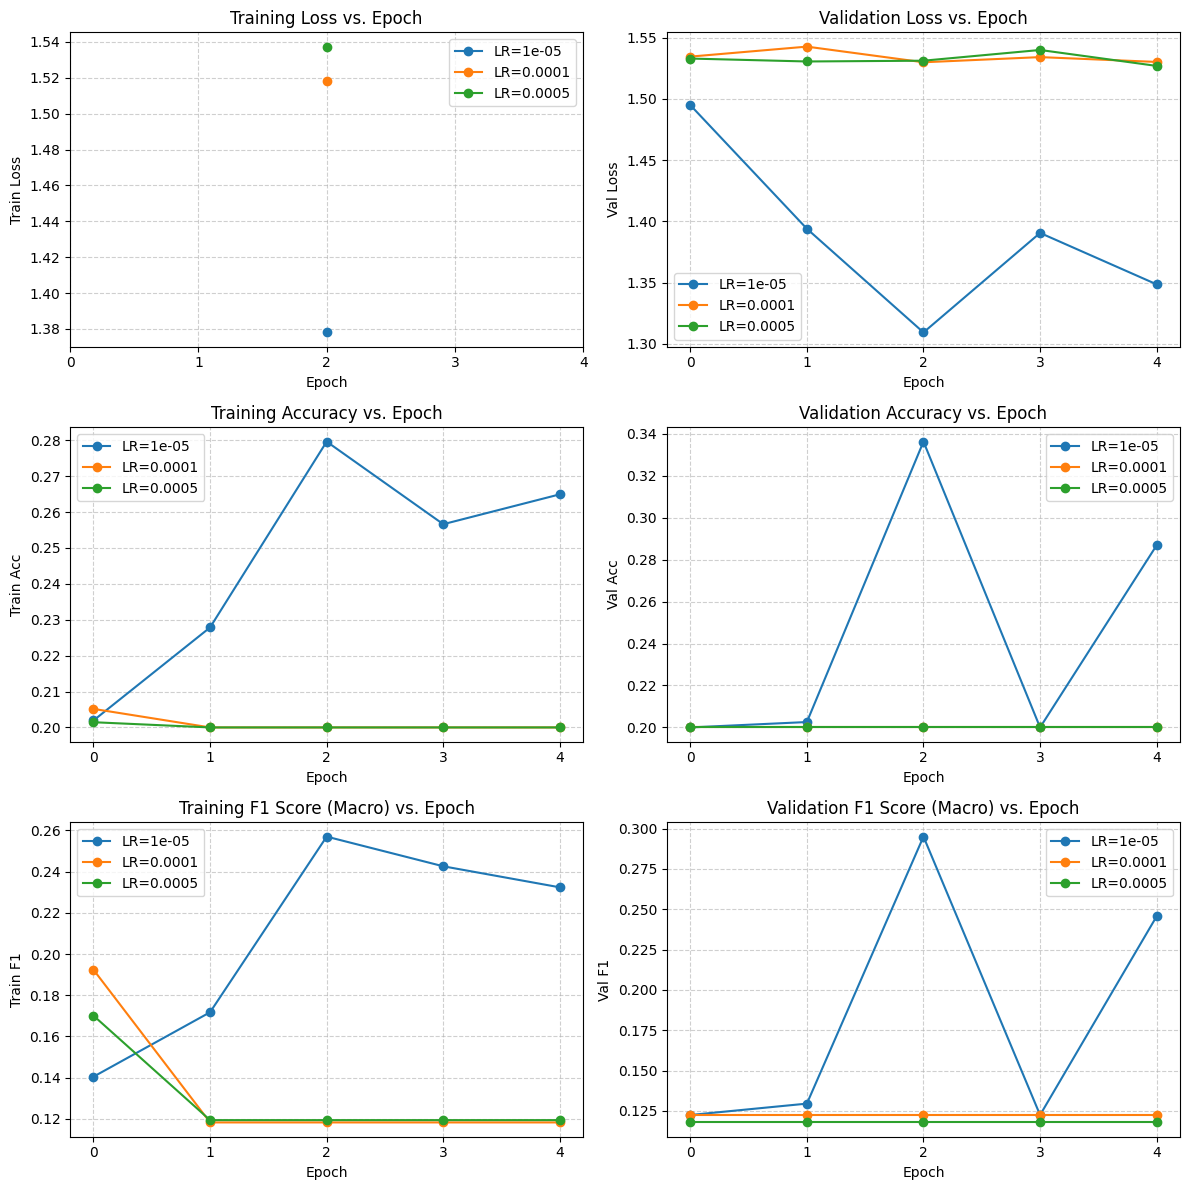


--- Summary of Results ---


,Learning Rate,Final Train Loss,Final Val Loss,Final Train Accuracy,Final Val Accuracy,Final Train F1 (Macro),Final Val F1 (Macro)
0,0.00001,NaN,1.348550,0.264939,0.286857,0.232367,0.245670
1,0.00010,NaN,1.530182,0.200000,0.200000,0.118299,0.122358
2,0.00050,NaN,1.526941,0.200000,0.200000,0.119421,0.117912



--- Analysis Complete ---


In [ ]:
# Cell ID: Analyze Learning Rate Experiment Results

print("Cell: Analyzing Learning Rate Experiment Results...")

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Define the base directory where the experiment logs are saved
logs_base_dir = Path("/content/drive/MyDrive/sleep_logs_experiments/")

# Define the learning rates that were experimented
learning_rates_to_experiment = [1e-5, 1e-4, 5e-4]

print(f"Analyzing logs from: {logs_base_dir}")

# Dictionary to store the log dataframes for each learning rate
log_dataframes = {}

# Iterate through each learning rate and read its log file
for lr in learning_rates_to_experiment:
    lr_str_formatted = str(lr).replace('.', '_')
    logger_name = f"sleep_stage_training_lr_{lr_str_formatted}"
    log_dir = logs_base_dir / logger_name

    # Find the actual version directory (usually 'version_0', 'version_1', etc.)
    # Assuming the latest version is the one we want to analyze
    version_dirs = sorted([d for d in log_dir.iterdir() if d.is_dir() and d.name.startswith('version_')])

    if not version_dirs:
        print(f"WARNING: No version directory found for LR {lr} at {log_dir}. Skipping analysis for this LR.")
        continue

    latest_version_dir = version_dirs[-1] # Get the latest version directory
    log_file_path = latest_version_dir / "metrics.csv"

    if log_file_path.exists():
        print(f"Reading log file for LR {lr}: {log_file_path}")
        try:
            df_log = pd.read_csv(log_file_path)
            log_dataframes[lr] = df_log
            print(f"Successfully read log for LR {lr}. DataFrame shape: {df_log.shape}")
        except Exception as e:
            print(f"ERROR reading log file {log_file_path}: {e}. Skipping analysis for this LR.")
    else:
        print(f"WARNING: Log file not found for LR {lr} at {log_file_path}. Skipping analysis for this LR.")

print("\n--- Analysis of Training and Validation Metrics ---")

# Plotting metrics over epochs for each learning rate
metrics_to_plot = ['train_loss', 'val_loss', 'train_acc_epoch', 'val_acc', 'train_f1_epoch', 'val_f1']
titles = {
    'train_loss': 'Training Loss vs. Epoch',
    'val_loss': 'Validation Loss vs. Epoch',
    'train_acc_epoch': 'Training Accuracy vs. Epoch',
    'val_acc': 'Validation Accuracy vs. Epoch',
    'train_f1_epoch': 'Training F1 Score (Macro) vs. Epoch',
    'val_f1': 'Validation F1 Score (Macro) vs. Epoch',
}

# Determine the number of plots based on available metrics
num_metrics = len(metrics_to_plot)
# Calculate grid size for subplots (e.g., 2 columns)
n_cols = 2
n_rows = (num_metrics + n_cols - 1) // n_cols

plt.figure(figsize=(12, n_rows * 4))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(titles.get(metric, metric))
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace('_epoch', '').replace('_', ' ').title()) # Improve label formatting

    for lr, df_log in log_dataframes.items():
        # Filter out rows where the metric is NaN (e.g., validation metrics are only logged per epoch)
        # And ensure we only plot epoch-level metrics over epochs
        if 'epoch' in df_log.columns and metric in df_log.columns:
            # For epoch-level metrics (val_loss, val_acc, val_f1), filter out step-level logs
            if metric.startswith('val_') or metric.endswith('_epoch'):
                 df_metric = df_log.dropna(subset=[metric, 'epoch']).drop_duplicates(subset=['epoch'])
                 # Ensure epoch is integer
                 df_metric['epoch'] = df_metric['epoch'].astype(int)
                 plt.plot(df_metric['epoch'], df_metric[metric], marker='o', linestyle='-', label=f'LR={lr}')
            # For train metrics logged on step, plot against step or aggregate by epoch if needed
            # For simplicity here, let's assume train_loss is also available per epoch or plot step-wise if needed.
            # Based on the logs, train_loss is logged per step, train_acc and train_f1 are logged per epoch.
            elif metric.startswith('train_loss'):
                 # Filter out rows where 'step' is NaN (epoch-level rows) and metric is not NaN
                 df_metric = df_log.dropna(subset=[metric, 'step']).drop_duplicates(subset=['step'])
                 # Plotting train_loss against step might be too noisy.
                 # Let's try to plot the average train_loss per epoch if possible from the logs,
                 # or just skip if it's only step-wise and too granular.
                 # The logs show 'train_loss' with 'step' and 'epoch'. Let's average by epoch.
                 df_metric_epoch_avg = df_log.dropna(subset=[metric, 'epoch']).groupby('epoch')[metric].mean().reset_index()
                 df_metric_epoch_avg['epoch'] = df_metric_epoch_avg['epoch'].astype(int)
                 plt.plot(df_metric_epoch_avg['epoch'], df_metric_epoch_avg[metric], marker='o', linestyle='-', label=f'LR={lr}')

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(range(int(df_log['epoch'].min() if 'epoch' in df_log.columns else 0),
                     int(df_log['epoch'].max() if 'epoch' in df_log.columns else epochs_per_chunk) + 1))


plt.tight_layout()
plt.show()


print("\n--- Summary of Results ---")
# Summarize the final metrics for each learning rate
summary_data = []
for lr, df_log in log_dataframes.items():
    # Find the last epoch's validation metrics
    if 'epoch' in df_log.columns and not df_log['epoch'].isnull().all():
        last_epoch = df_log['epoch'].dropna().max()
        # Get the row(s) for the last epoch where validation metrics are logged
        df_last_epoch_val = df_log[(df_log['epoch'] == last_epoch) & df_log['val_loss'].notna()]

        if not df_last_epoch_val.empty:
            # Assuming there's only one row per epoch for validation metrics
            final_val_loss = df_last_epoch_val['val_loss'].iloc[0]
            final_val_acc = df_last_epoch_val['val_acc'].iloc[0]
            final_val_f1 = df_last_epoch_val['val_f1'].iloc[0]

            # Get the last epoch's training metrics (might be logged on epoch or averaged)
            df_last_epoch_train = df_log[(df_log['epoch'] == last_epoch)] # Get all rows for the last epoch

            final_train_loss = df_last_epoch_train['train_loss'].mean() if 'train_loss' in df_last_epoch_train.columns else None # Average if logged per step
            final_train_acc = df_last_epoch_train['train_acc_epoch'].iloc[-1] if 'train_acc_epoch' in df_last_epoch_train.columns and not df_last_epoch_train['train_acc_epoch'].isnull().all() else None
            final_train_f1 = df_last_epoch_train['train_f1_epoch'].iloc[-1] if 'train_f1_epoch' in df_last_epoch_train.columns and not df_last_epoch_train['train_f1_epoch'].isnull().all() else None


            summary_data.append({
                'Learning Rate': lr,
                'Final Train Loss': final_train_loss,
                'Final Val Loss': final_val_loss,
                'Final Train Accuracy': final_train_acc,
                'Final Val Accuracy': final_val_acc,
                'Final Train F1 (Macro)': final_train_f1,
                'Final Val F1 (Macro)': final_val_f1,
            })
        else:
            print(f"WARNING: No validation metrics found for the last epoch ({last_epoch}) for LR {lr}.")
            summary_data.append({'Learning Rate': lr, 'Notes': 'No validation metrics found for last epoch'})
    else:
         print(f"WARNING: No epoch information found in logs for LR {lr}. Cannot summarize.")
         summary_data.append({'Learning Rate': lr, 'Notes': 'No epoch info in logs'})


df_summary = pd.DataFrame(summary_data)
display(df_summary)

print("\n--- Analysis Complete ---")